In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

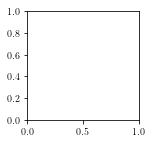

In [2]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [3]:
def get_major_fre(*arg, **kwargs):
    return spf_tb.get_major_fre(*arg, **kwargs)
    
def load_rand_data_pickle_dir_v3(t_dir, t_headle='(.*?).pickle', n_load=None, rand_mode=False, 
                                 add_info=False): 
    t_path = os.listdir(t_dir)
    filename_list = [filename for filename in t_path if re.match(t_headle, filename) is not None]
    wt_list = []
    pickle_path_list = []
    mean_eta_list = []
    std_psi_list = []
    dx_list = []
    dy_list = []
    dz_list = []
    dpsi_list = []
    
    n_load = len(filename_list) if n_load is None else n_load
    assert n_load <= len(filename_list)
    if rand_mode:
        tidx = np.random.choice(len(filename_list), n_load, replace=False)
    else:
        tidx = np.arange(n_load)
    use_filename_list = np.array(filename_list)[tidx]

    for tname in use_filename_list:
        tpath = os.path.join(t_dir, tname)
        with open(tpath, 'rb') as handle:
                tpick = pickle.load(handle)
        wt_list.append(tpick['omega_tail'])
        pickle_path_list.append(tpath)

        # fft rule
        tx = tpick['Table_t']
        tmin = np.max((0, tx.max() - 1000))
        idx = tx > tmin
        freq_pk = get_major_fre(tx[idx], tpick['Table_theta'][idx])
        idx = tx > (tx.max() - 1 / freq_pk * 10)
        mean_eta_list.append(np.mean(tpick['Table_eta'][idx]))
        std_psi_list.append((np.mean(tpick['Table_psi'][idx]), np.std(tpick['Table_psi'][idx])))
        for i0, tlist in enumerate((dx_list, dy_list, dz_list)):
            tpoly = np.polyfit(tx[idx], tpick['Table_X'][idx, i0], 1, w=np.blackman(idx.sum()))
            tlist.append(tpoly[0])
        dpsi_list.append(np.polyfit(tx[idx], spf_tb.get_increase_angle(tpick['Table_psi'][idx]), 
                                    deg=1, w=np.blackman(idx.sum()))[0])

    wt_list = np.hstack(wt_list)
    pickle_path_list = np.array(pickle_path_list)
    mean_eta_list = np.hstack(mean_eta_list)
    std_psi_list = np.array(std_psi_list)
    dx_list = np.hstack(dx_list)
    dy_list = np.hstack(dy_list)
    dz_list = np.hstack(dz_list)
    dpsi_list = np.hstack(dpsi_list)
    if add_info:
        return dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, \
                (std_psi_list, dpsi_list)
    else: 
        return dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list


In [11]:
n_load = None
rand_mode=False
# job_dir_list = ['ecoC01B05_inithphps_k', 
#                 'ecoC01B05_inithphps_l', 
#                 'ecoC01B05_inithphps_m', ]
job_dir_list = ['ecoC01B05_inithphps_n', ]
t_headle = '(.*?).pickle'
data_list = []

for job_dir in job_dir_list:
    use_dir = os.path.join(os.getcwd(), job_dir)
    dir_list = [o for o in os.listdir(use_dir) if (os.path.isdir(os.path.join(use_dir, o)) 
                                                   and not o.startswith('.'))]
    print(use_dir)
    for sub_dir in tqdm_notebook(dir_list[:]):
        t_dir = os.path.join(use_dir, sub_dir)
        data_list.append(load_rand_data_pickle_dir_v3(t_dir, t_headle, n_load=n_load, rand_mode=rand_mode, 
                                                      add_info=True))
    # data_list = np.array(data_list)

/home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_inithphps_n


In [ ]:
len(dir_list)

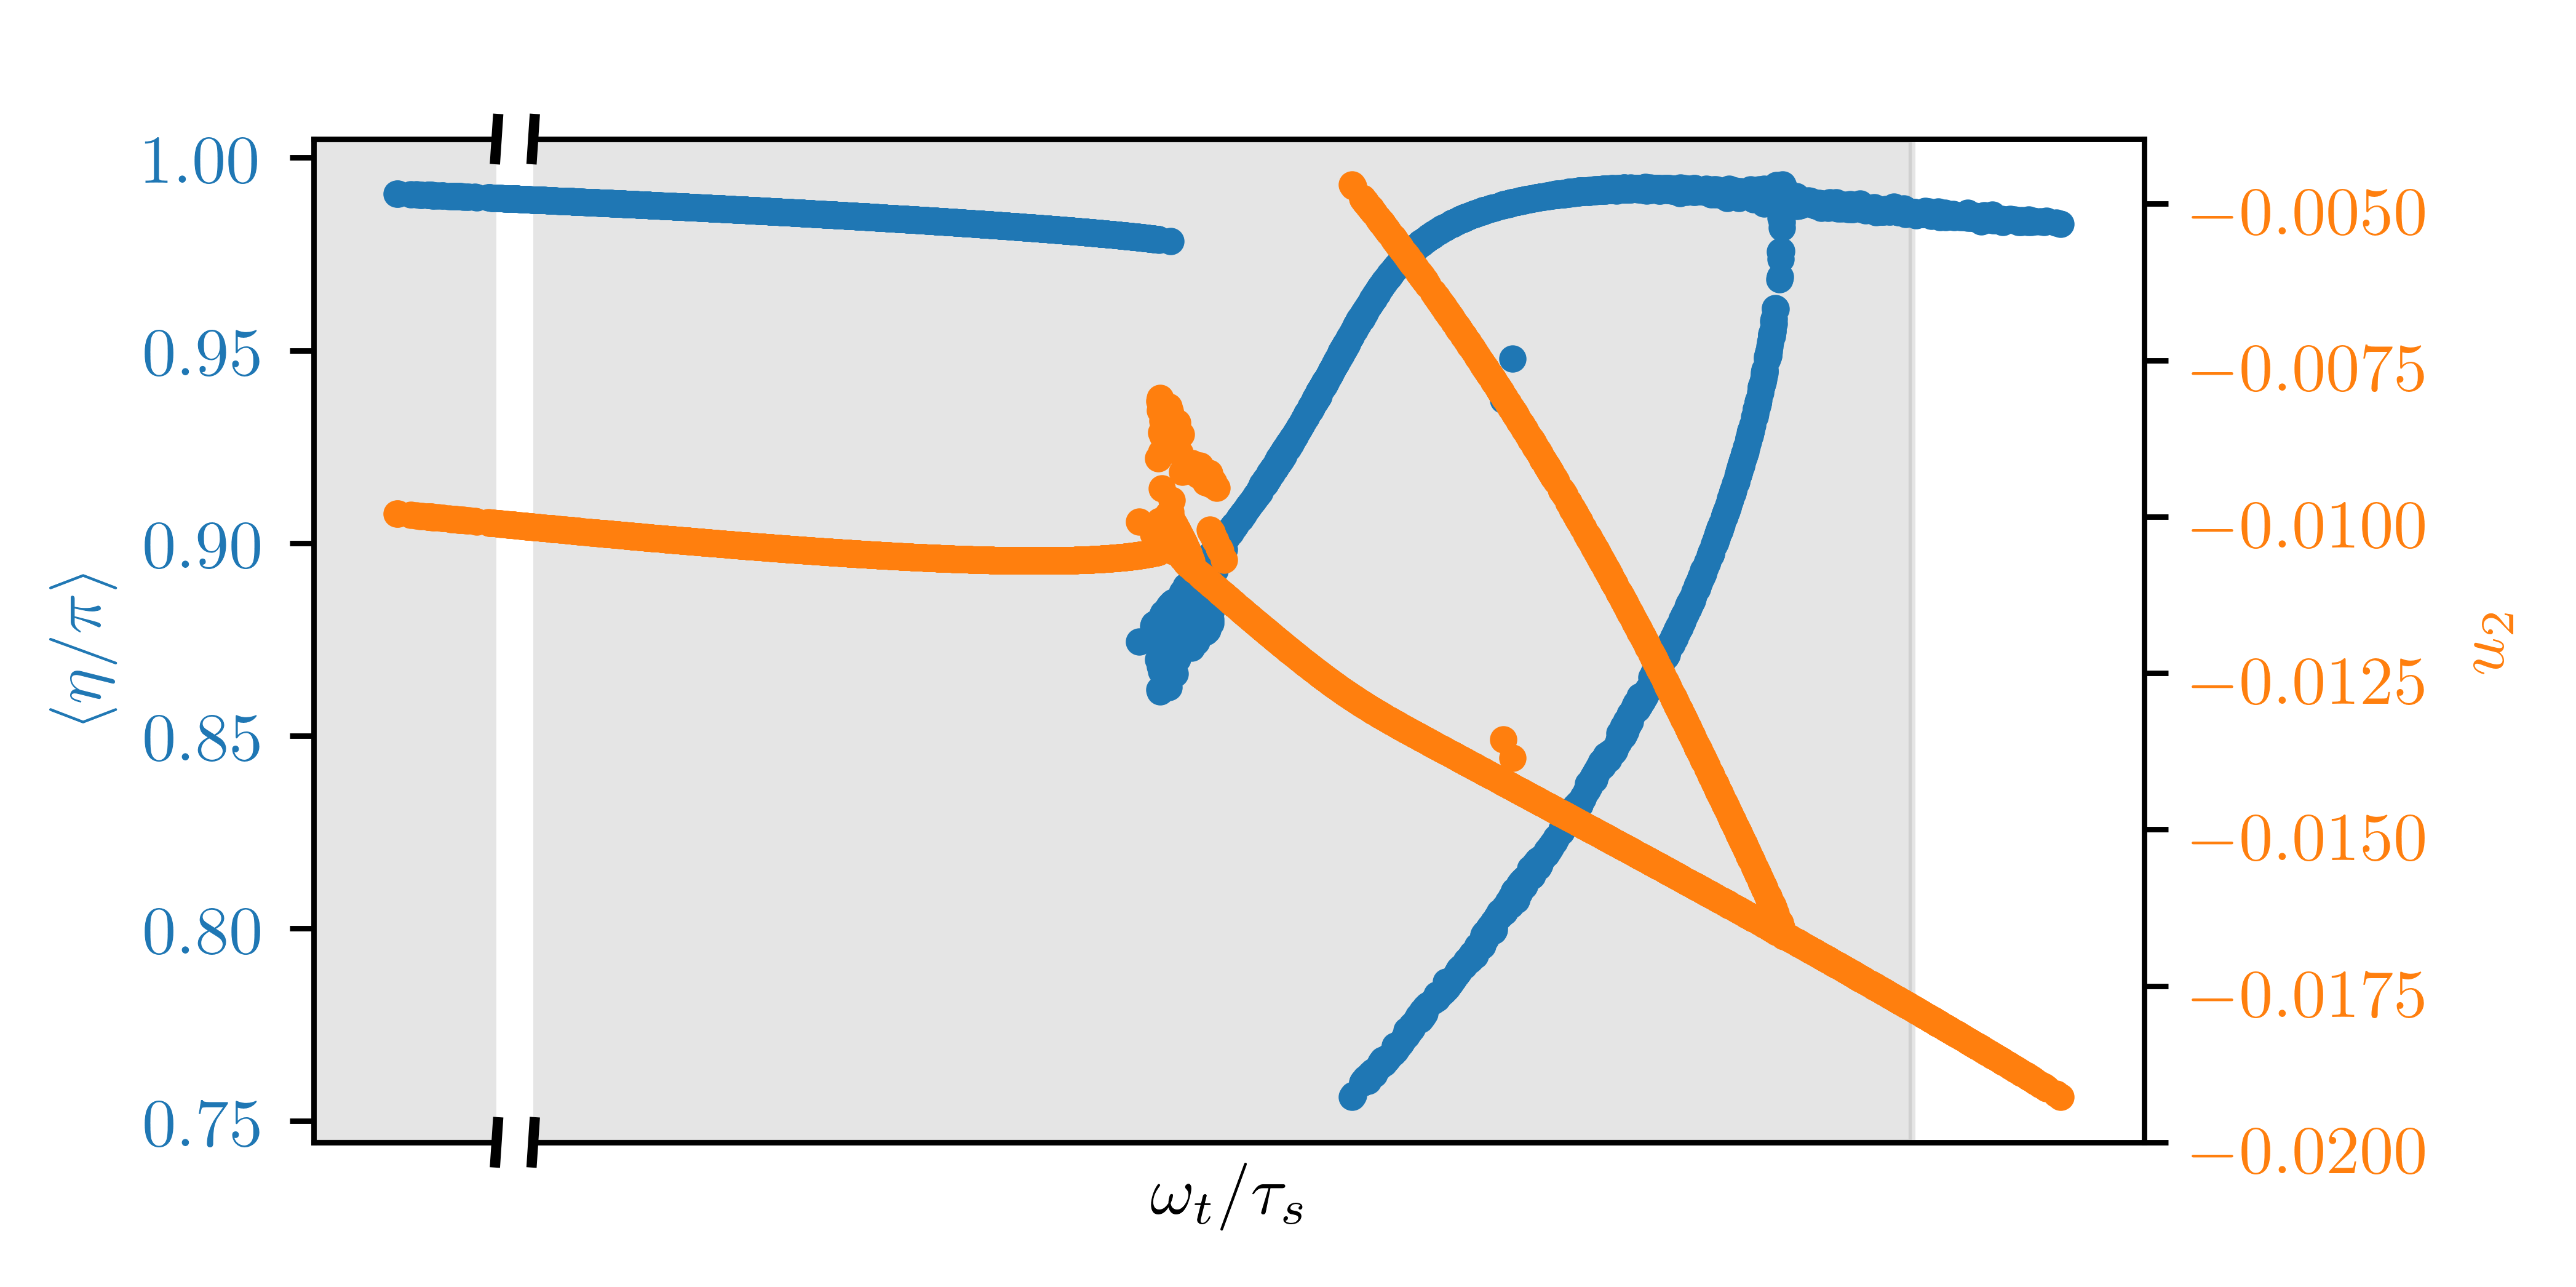

In [12]:
# %matplotlib notebook
%matplotlib inline

figsize = np.array((16, 9)) * 0.3
dpi = 800 if 'inline' in matplotlib.get_backend() else 100
linthreshx = 1e-3
linscalex = 0.5
color0 = 'C0'
color1 = 'C1'

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.1, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.1)))

axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.1, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)
axi1 = fig.add_axes(axi_pos)
axi2 = axi1.twinx()
axi1.tick_params(axis='y', labelcolor=color0)
axi2.tick_params(axis='y', labelcolor=color1)

for _ in data_list[:]:
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    axi1.plot(wt_list[tidx], mean_eta_list[tidx] / np.pi, '.', color=color0, label='')
    axi2.plot(wt_list[tidx], dy_list[tidx], '.', color=color1)
axi1.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi2.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi1.patch.set_alpha(0)
axi1.set_xlabel('$\\omega_t / \\tau_s$')
axi1.set_ylabel('$\\langle \\eta / \\pi \\rangle$', color=color0)
axi2.set_ylabel('$u_2$', color=color1)
for t1 in axi1.spines:
    axi1.spines[t1].set_visible(False)
for t1 in axi2.spines:
    axi2.spines[t1].set_visible(False)

axi.set_xlim(axi1.get_xlim())
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.tick_params(axis=u'both', which=u'both',length=0)
axi.set_xticklabels([])
axi.set_yticklabels([])
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
# plt.tight_layout()

(2.1188915, 5.0786945) (0.7444240885051545, 1.0048493182293763)


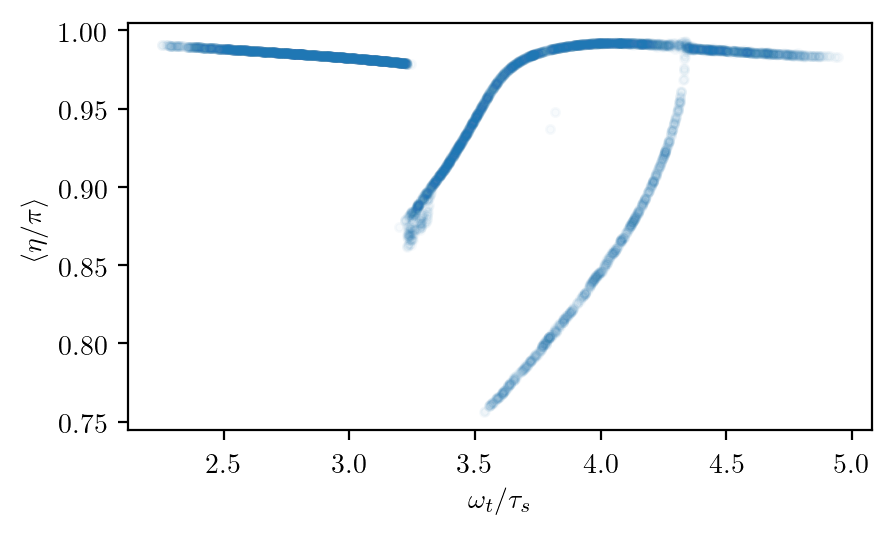

In [13]:
# %matplotlib notebook
%matplotlib inline

figsize = np.array((16, 9)) * 0.3
dpi = 200 if 'inline' in matplotlib.get_backend() else 100
linthreshx = 1e-3
linscalex = 0.5

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.1, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.1)))

# axi3 = fig.add_axes(axi_pos + dpos)
# axi3.set_xticklabels([])
# axi3.set_yticklabels([])
# for t1 in axi3.spines:
#     axi3.spines[t1].set_visible(False)
# axi3.tick_params(axis=u'both', which=u'both',length=0)
# dpos = np.array(((axi_pos[2] * 0.1, 0, axi_pos[2] * -0.98, 0)))
# axi4 = fig.add_axes(axi_pos + dpos)
# axi4.set_xticklabels([])
# axi4.set_yticklabels([])
# for t1 in axi4.spines:
#     axi4.spines[t1].set_visible(False)
# axi4.tick_params(axis=u'both', which=u'both',length=0)
# td = 0.02 # how big to make the diagonal lines in axes coordinates
# kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
# axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
# axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

axi1 = fig.add_axes(axi_pos)
for _ in data_list[:]:
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    axi1.plot(wt_list[tidx], mean_eta_list[tidx] / np.pi, '.C0', alpha=0.03)
# axi1.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi1.patch.set_alpha(0)
axi1.set_xlabel('$\\omega_t / \\tau_s$')
axi1.set_ylabel('$\\langle \\eta / \\pi \\rangle$')
for t1 in axi1.spines:
    axi1.spines[t1].set_visible(False)

axi.set_xlim(axi1.get_xlim())
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.tick_params(axis=u'both', which=u'both',length=0)
axi.set_xticklabels([])
axi.set_yticklabels([])
# axi.axvspan(0, 0.015, alpha=0.05, color='gray')
# axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
# axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
print(axi1.get_xlim(), axi1.get_ylim())

(2.1188915, 5.0786945) (-0.019999769940484174, -0.00396546635051899)


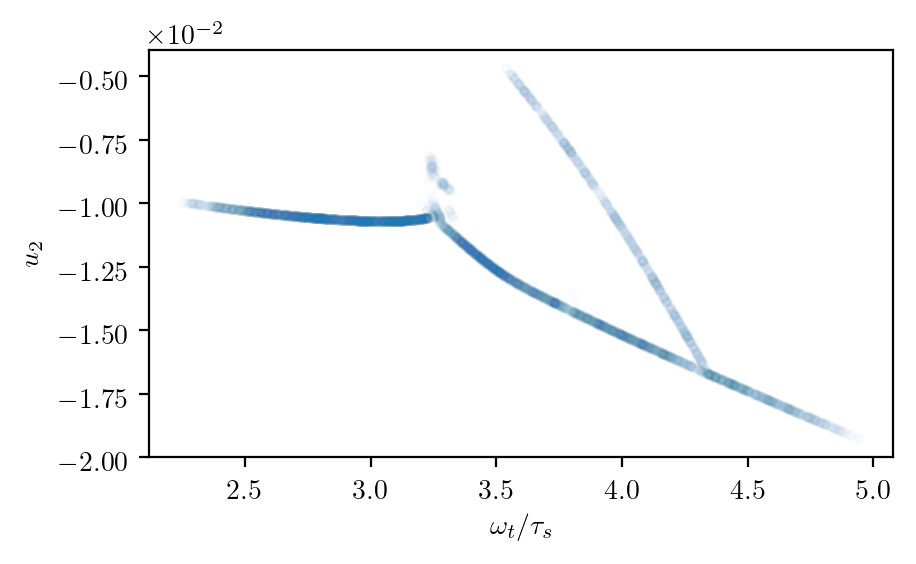

In [14]:
# %matplotlib notebook
%matplotlib inline

figsize = np.array((16, 9)) * 0.3
dpi = 200 if 'inline' in matplotlib.get_backend() else 100
linthreshx = 1e-3
linscalex = 0.5

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.1, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.1)))

# axi3 = fig.add_axes(axi_pos + dpos)
# axi3.set_xticklabels([])
# axi3.set_yticklabels([])
# for t1 in axi3.spines:
#     axi3.spines[t1].set_visible(False)
# axi3.tick_params(axis=u'both', which=u'both',length=0)
# dpos = np.array(((axi_pos[2] * 0.1, 0, axi_pos[2] * -0.98, 0)))
# axi4 = fig.add_axes(axi_pos + dpos)
# axi4.set_xticklabels([])
# axi4.set_yticklabels([])
# for t1 in axi4.spines:
#     axi4.spines[t1].set_visible(False)
# axi4.tick_params(axis=u'both', which=u'both',length=0)
# td = 0.02 # how big to make the diagonal lines in axes coordinates
# kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
# axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
# axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

axi1 = fig.add_axes(axi_pos)
for _ in data_list[:]:
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    axi1.plot(wt_list[tidx], dy_list[tidx], '.C0', alpha=0.01)
# axi1.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi1.patch.set_alpha(0)
axi1.set_xlabel('$\\omega_t / \\tau_s$')
axi1.set_ylabel('$u_2$')
for t1 in axi1.spines:
    axi1.spines[t1].set_visible(False)
axi1.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

axi.set_xlim(axi1.get_xlim())
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.tick_params(axis=u'both', which=u'both',length=0)
axi.set_xticklabels([])
axi.set_yticklabels([])
# axi.axvspan(0, 0.015, alpha=0.05, color='gray')
# axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
# axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
print(axi1.get_xlim(), axi1.get_ylim())

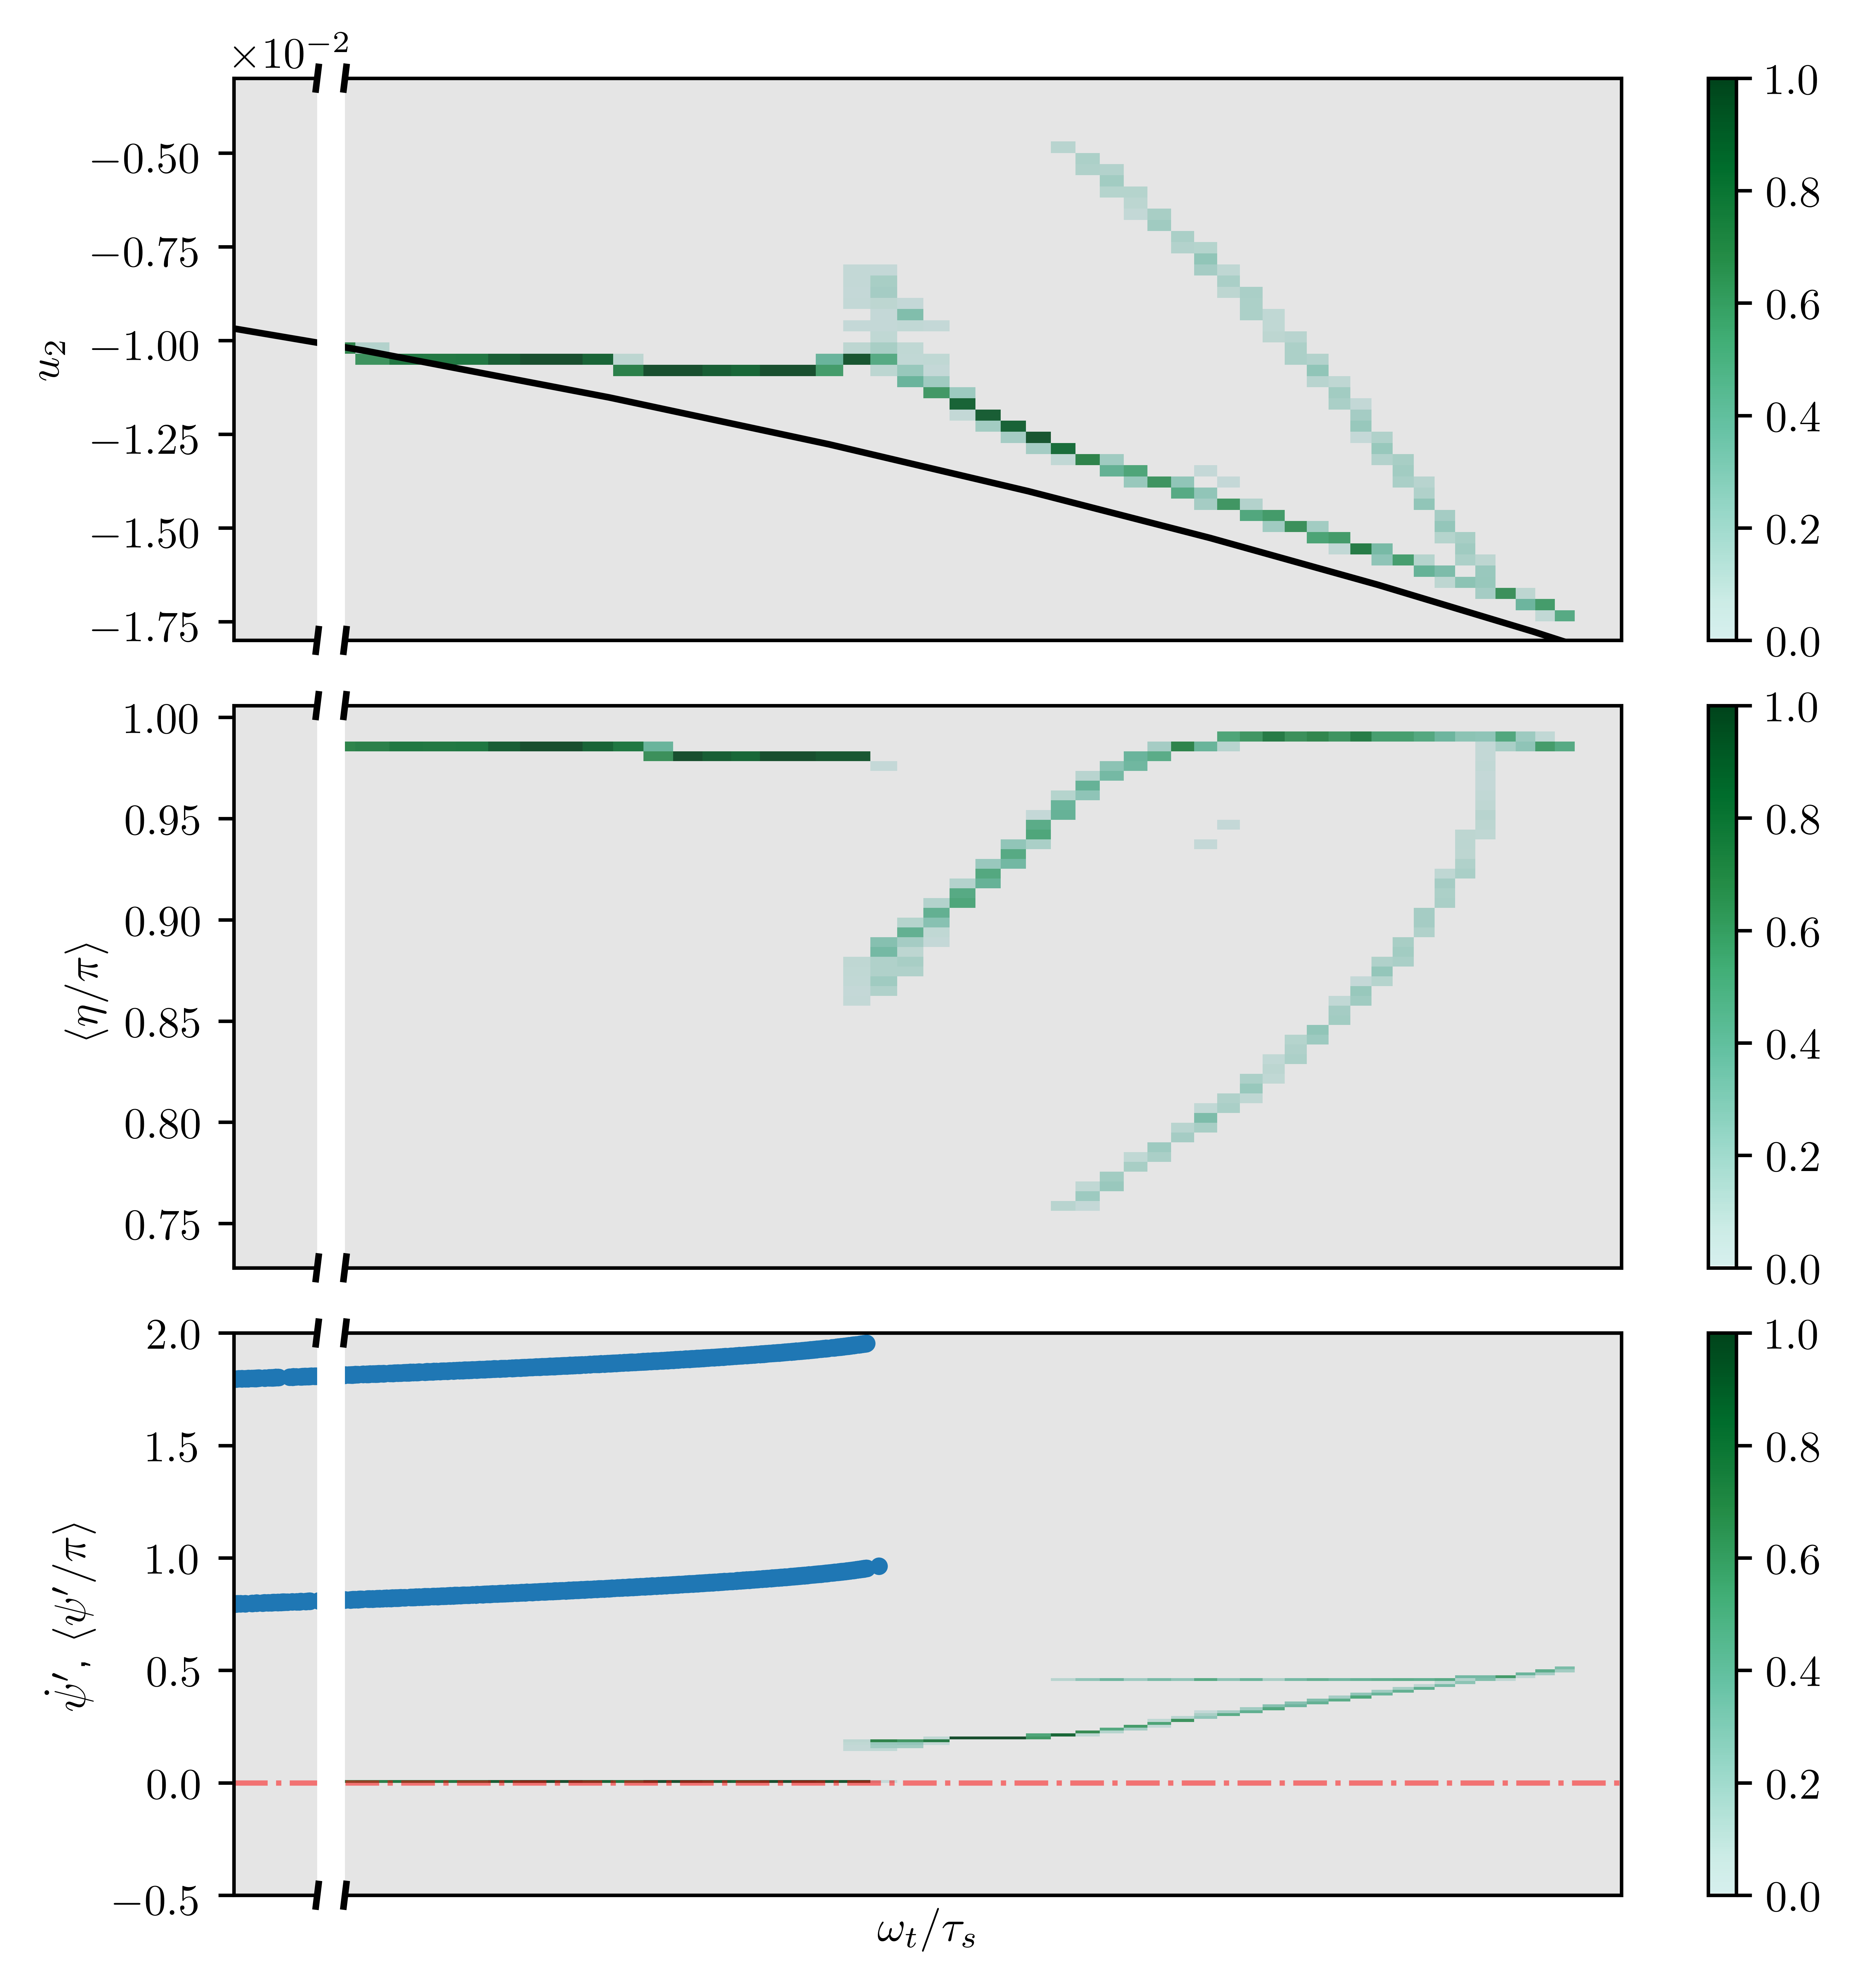

In [15]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import colorbar
from matplotlib import colors as mcolors

# figsize = np.array((16, 9)) * 0.4
figsize = np.array((16, 16)) * 0.4
markersize = 6
dpi = 1000 if 'inline' in matplotlib.get_backend() else 100
tcolors = np.vstack(((1, 1, 1, 1), plt.get_cmap('BuGn')(np.linspace(0.2, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', tcolors)
# norm = mcolors.LogNorm()
norm = mcolors.Normalize(vmin=0, vmax=1)

# xlim = (-0.0001, 115)
# ylim0 = (-0.43, 0.05)
# ylim1 = (0.45, 1.02)

# xlim = (-0.0001, 10.5)
# linthreshx, linscalex = 1e-3,  0.5
# ylim0 = (-0.04221, 0.00910)
# nyaxis0 = 50
# ylim1 = (0.45, 1.02)
# nyaxis1 = 50
# ylim2 = (-0.5, 2)
# nyaxis2 = 50
# linthreshy2, linscaley2 = 0.01, 1
# omega_tail_list = np.hstack((0, 10 ** np.linspace(-3, 1, 50)[:-1]))
# pickle_handle_list = ['C1', 'C4b']

xlim = (2.4, 4.6)
linthreshx, linscalex = 1e-3,  0.5
ylim0 = (-0.018, -0.003)
nyaxis0 = 50
ylim1 = (0.7280652964174723, 1.0058249245131092)
nyaxis1 = 50
ylim2 = (-0.5, 2)
nyaxis2 = 50
linthreshy2, linscaley2 = 0.01, 1
omega_tail_list = np.linspace(2.5, 4.5, 50)
pickle_handle_list = ['C1', 'C4b']

pickle_list = []
for pickle_handle in pickle_handle_list:
    pickle_name = '%s_jmp.pickle' % pickle_handle
    with open(pickle_name, 'rb') as handle:
        pickle_list.append(pickle.load(handle))

fig, axs = plt.subplots(3, 1, figsize=figsize, dpi=dpi)
# fig, axs = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
##########################################
axi = axs[0]
# dy, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(dy_list[tidx])
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis0))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im0 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_xticklabels([])
axi.set_ylabel('$u_2$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xlim(xlim)
axi.set_ylim(ylim0)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
for tpickle in pickle_list:
    tomega_tail_list, tmean_eta_list, tdy_list = tpickle
    axi.plot(tomega_tail_list, tdy_list, '.', markersize=markersize)
tx = np.linspace(1, 10, 30)
ty = tx * -4.02494122e-03
axi.plot(tx, ty, '-k')

##########################################
axi = axs[1]
# mean_eta, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(mean_eta_list[tidx] / np.pi)
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis1))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im1 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_xticklabels([])
axi.set_ylabel('$\\langle \\eta / \\pi \\rangle$')
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xlim(xlim)
axi.set_ylim(ylim1)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
for tpickle in pickle_list:
    tomega_tail_list, tmean_eta_list, tdy_list = tpickle
    axi.plot(tomega_tail_list, np.array(tmean_eta_list) / np.pi, '.', markersize=markersize)
    
##########################################
axi = axs[2]
# # version1, mean_psi and std_psi, contour plot
# wt_all = []
# ty_all = []
# tyerr_all = []
# for i0, _ in enumerate(data_list[:]):
#     dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, add_info = _
#     tidx = np.argsort(wt_list)
#     wt_all.append(wt_list[tidx])
#     ty_all.append(add_info[0][tidx, 0] / np.pi)
#     tyerr_all.append(add_info[0][tidx, 1] / np.pi)
# wt_all = np.array(wt_all)
# ty_all = np.array(ty_all)
# tyerr_all = np.array(tyerr_all)
# bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis2))
# tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
# im2 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
# axi.plot(np.hstack(wt_all), np.hstack(tyerr_all), '.')
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
# axi.set_ylabel('$\\langle (\\psi\'=\\psi+\\psi_t) / \\pi \\rangle$')
# axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# axi.set_xlim(xlim)
# axi.set_ylim(ylim2)
# axi.axvspan(0, 0.015, alpha=0.05, color='gray')
# axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
# axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')

# # version 2, dpsi
# tx = np.hstack([i0[3] for i0 in data_list[:]])
# ty = np.hstack([i0[6][1] for i0 in data_list[:]])
# axi.plot(tx, ty, '.')
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.set_yscale('symlog', linthreshy=linthreshy2, linscaley=linscaley2)
# axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
# axi.set_ylabel('$\\dot \\psi$')
# # axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# axi.set_xlim(xlim)
# axi.set_ylim(ylim2)
# axi.axvspan(0, 0.015, alpha=0.05, color='gray')
# axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
# axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')

# version1, dpsi, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, add_info = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(add_info[1][tidx])
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis2))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im2 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
axi.plot(xlim, np.zeros_like(xlim), '-.r', linewidth=markersize * 0.2, alpha=0.5)
# mean_psi
tx = np.hstack([i0[3] for i0 in data_list[:]])
ty = np.hstack([i0[6][0][:, 0] for i0 in data_list[:]]) / np.pi
tyerr = np.hstack([i0[6][0][:, 1] for i0 in data_list[:]]) / np.pi
tidx = tyerr < 0.1
tx = tx[tidx]
ty = ty[tidx]
axi.plot(tx, ty, '.')
# et.al. 
axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
# axi.set_yscale('symlog', linthreshy=linthreshy2, linscaley=linscaley2)
axi.patch.set_alpha(0)
axi.set_xlabel('$\\omega_t / \\tau_s$')
axi.set_ylabel('$\\dot \\psi\'$, $\\langle \\psi\' / \\pi \\rangle$')
axi.set_xlim(xlim)
axi.set_ylim(ylim2)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')

##########################################
plt.tight_layout()
# colorbar
axi = axs[0]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im0, cax=caxi)
# colorbar
axi = axs[1]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im1, cax=caxi)
# colorbar
axi = axs[2]
caxi = colorbar.make_axes(axi, location='right', aspect=20, shrink=1, fraction=0.15)[0]
fig.colorbar(im2, cax=caxi)
# set position
axi_pos_base = axs[0].get_position().bounds
for axi in axs:
    axi_pos = axi.get_position().bounds
    tpos = (axi_pos_base[0], axi_pos[1], axi_pos_base[2], axi_pos_base[3])
    axi.set_position(tpos)

##########################################
axi = axs[0]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

##########################################
axi = axs[1]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

##########################################
axi = axs[2]
# the break lines
axi_pos = axi.get_position().bounds
tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
dpos = np.array(((axi_pos[2] * 0.06, axi_pos[3] * -0.01, axi_pos[2] * -0.98, axi_pos[3] * 0.02)))
axi3 = fig.add_axes(axi_pos + dpos)
axi3.set_xticklabels([])
axi3.set_yticklabels([])
for t1 in axi3.spines:
    axi3.spines[t1].set_visible(False)
axi3.tick_params(axis=u'both', which=u'both',length=0)
dpos = np.array(((axi_pos[2] * 0.06, 0, axi_pos[2] * -0.98, 0)))
axi4 = fig.add_axes(axi_pos + dpos)
axi4.set_xticklabels([])
axi4.set_yticklabels([])
for t1 in axi4.spines:
    axi4.spines[t1].set_visible(False)
axi4.tick_params(axis=u'both', which=u'both',length=0)
td = 0.02 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

# # the break lines, yaxis1 (lower)
# axi_pos = axi.get_position().bounds
# tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
# dpos = np.array(((axi_pos[2] * -0.01, axi_pos[3] * 0.37, axi_pos[2] * 0.02, axi_pos[3] * -0.97)))
# axi3 = fig.add_axes(axi_pos + dpos)
# axi3.set_xticklabels([])
# axi3.set_yticklabels([])
# for t1 in axi3.spines:
#     axi3.spines[t1].set_visible(False)
# axi3.tick_params(axis=u'both', which=u'both',length=0)
# dpos = np.array(((0, axi_pos[3] * 0.37, 0, axi_pos[3] * -0.97)))
# axi4 = fig.add_axes(axi_pos + dpos)
# axi4.set_xticklabels([])
# axi4.set_yticklabels([])
# for t1 in axi4.spines:
#     axi4.spines[t1].set_visible(False)
# axi4.tick_params(axis=u'both', which=u'both',length=0)
# td = 0.003 # how big to make the diagonal lines in axes coordinates
# kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
# axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
# axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)

# # the break lines, yaxis2 (upper)
# axi_pos = axi.get_position().bounds
# tfct = axi_pos[2] / axi_pos[3] * figsize[0] / figsize[1]
# dpos = np.array(((axi_pos[2] * -0.01, axi_pos[3] * 0.52, axi_pos[2] * 0.02, axi_pos[3] * -0.97)))
# axi3 = fig.add_axes(axi_pos + dpos)
# axi3.set_xticklabels([])
# axi3.set_yticklabels([])
# for t1 in axi3.spines:
#     axi3.spines[t1].set_visible(False)
# axi3.tick_params(axis=u'both', which=u'both',length=0)
# dpos = np.array(((0, axi_pos[3] * 0.52, 0, axi_pos[3] * -0.97)))
# axi4 = fig.add_axes(axi_pos + dpos)
# axi4.set_xticklabels([])
# axi4.set_yticklabels([])
# for t1 in axi4.spines:
#     axi4.spines[t1].set_visible(False)
# axi4.tick_params(axis=u'both', which=u'both',length=0)
# td = 0.003 # how big to make the diagonal lines in axes coordinates
# kwargs = dict(transform=axi4.transAxes, color='k', clip_on=False)
# axi4.plot((-td * tfct,+td * tfct), (1-td,1+td), **kwargs)
# axi4.plot((-td * tfct,+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct), (-td,+td), **kwargs)
# axi4.plot((1-td * tfct,1+td * tfct),(1-td,1+td), **kwargs)


(2.4, 4.6) (-0.018, -0.003)


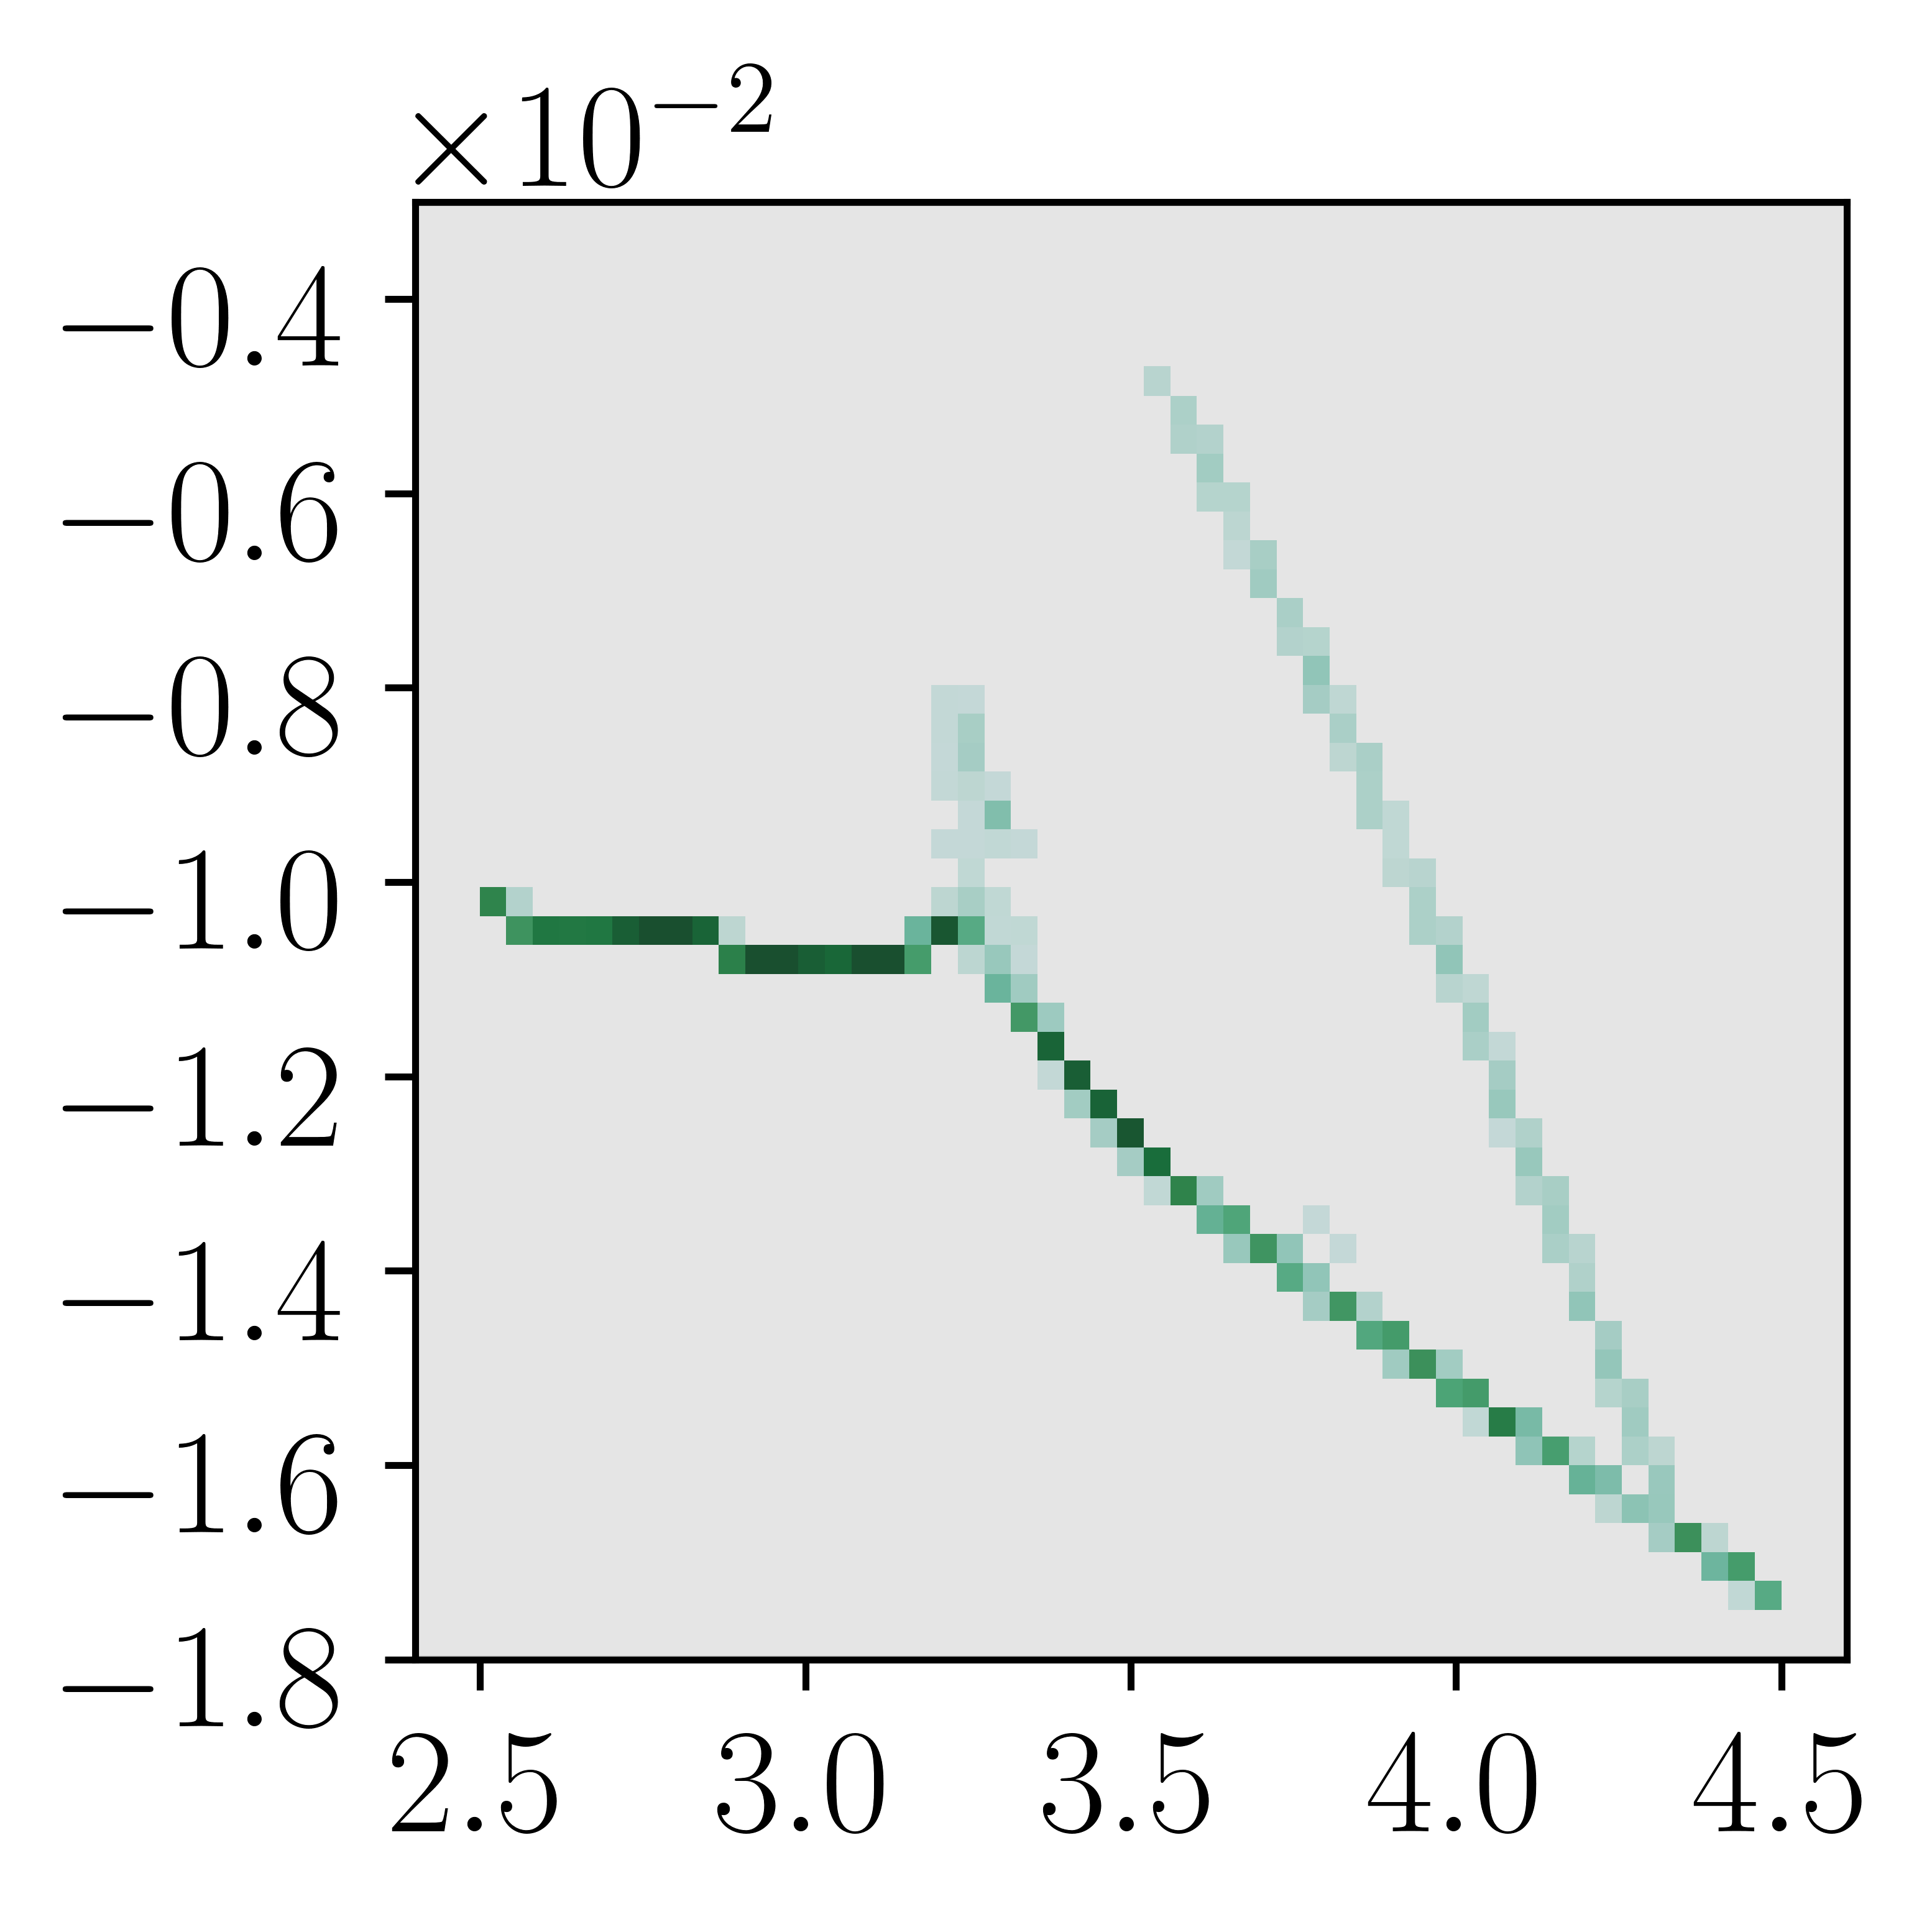

In [16]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import colorbar
from matplotlib import colors as mcolors

figsize = np.array((16, 16)) * 0.2
markersize = 6
dpi = 1000 if 'inline' in matplotlib.get_backend() else 100
tcolors = np.vstack(((1, 1, 1, 1), plt.get_cmap('BuGn')(np.linspace(0.2, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', tcolors)
norm = mcolors.Normalize(vmin=0, vmax=1)

xlim = (2.4, 4.6)
linthreshx, linscalex = 1e-3,  0.5
ylim0 = (-0.018, -0.003)
nyaxis0 = 50
omega_tail_list = np.linspace(2.5, 4.5, 50)

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
##########################################
# dy, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(dy_list[tidx])
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis0))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im0 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
# axi.set_xticklabels([])
# axi.set_ylabel('$u_2$')
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
axi.set_xlim(xlim)
axi.set_ylim(ylim0)
axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
axi.yaxis.get_offset_text().set_fontsize('xx-large')
plt.tight_layout()

print(axi.get_xlim(), axi.get_ylim())

In [ ]:
len(data_list)

(2.4, 4.6) (0.75, 1.01)


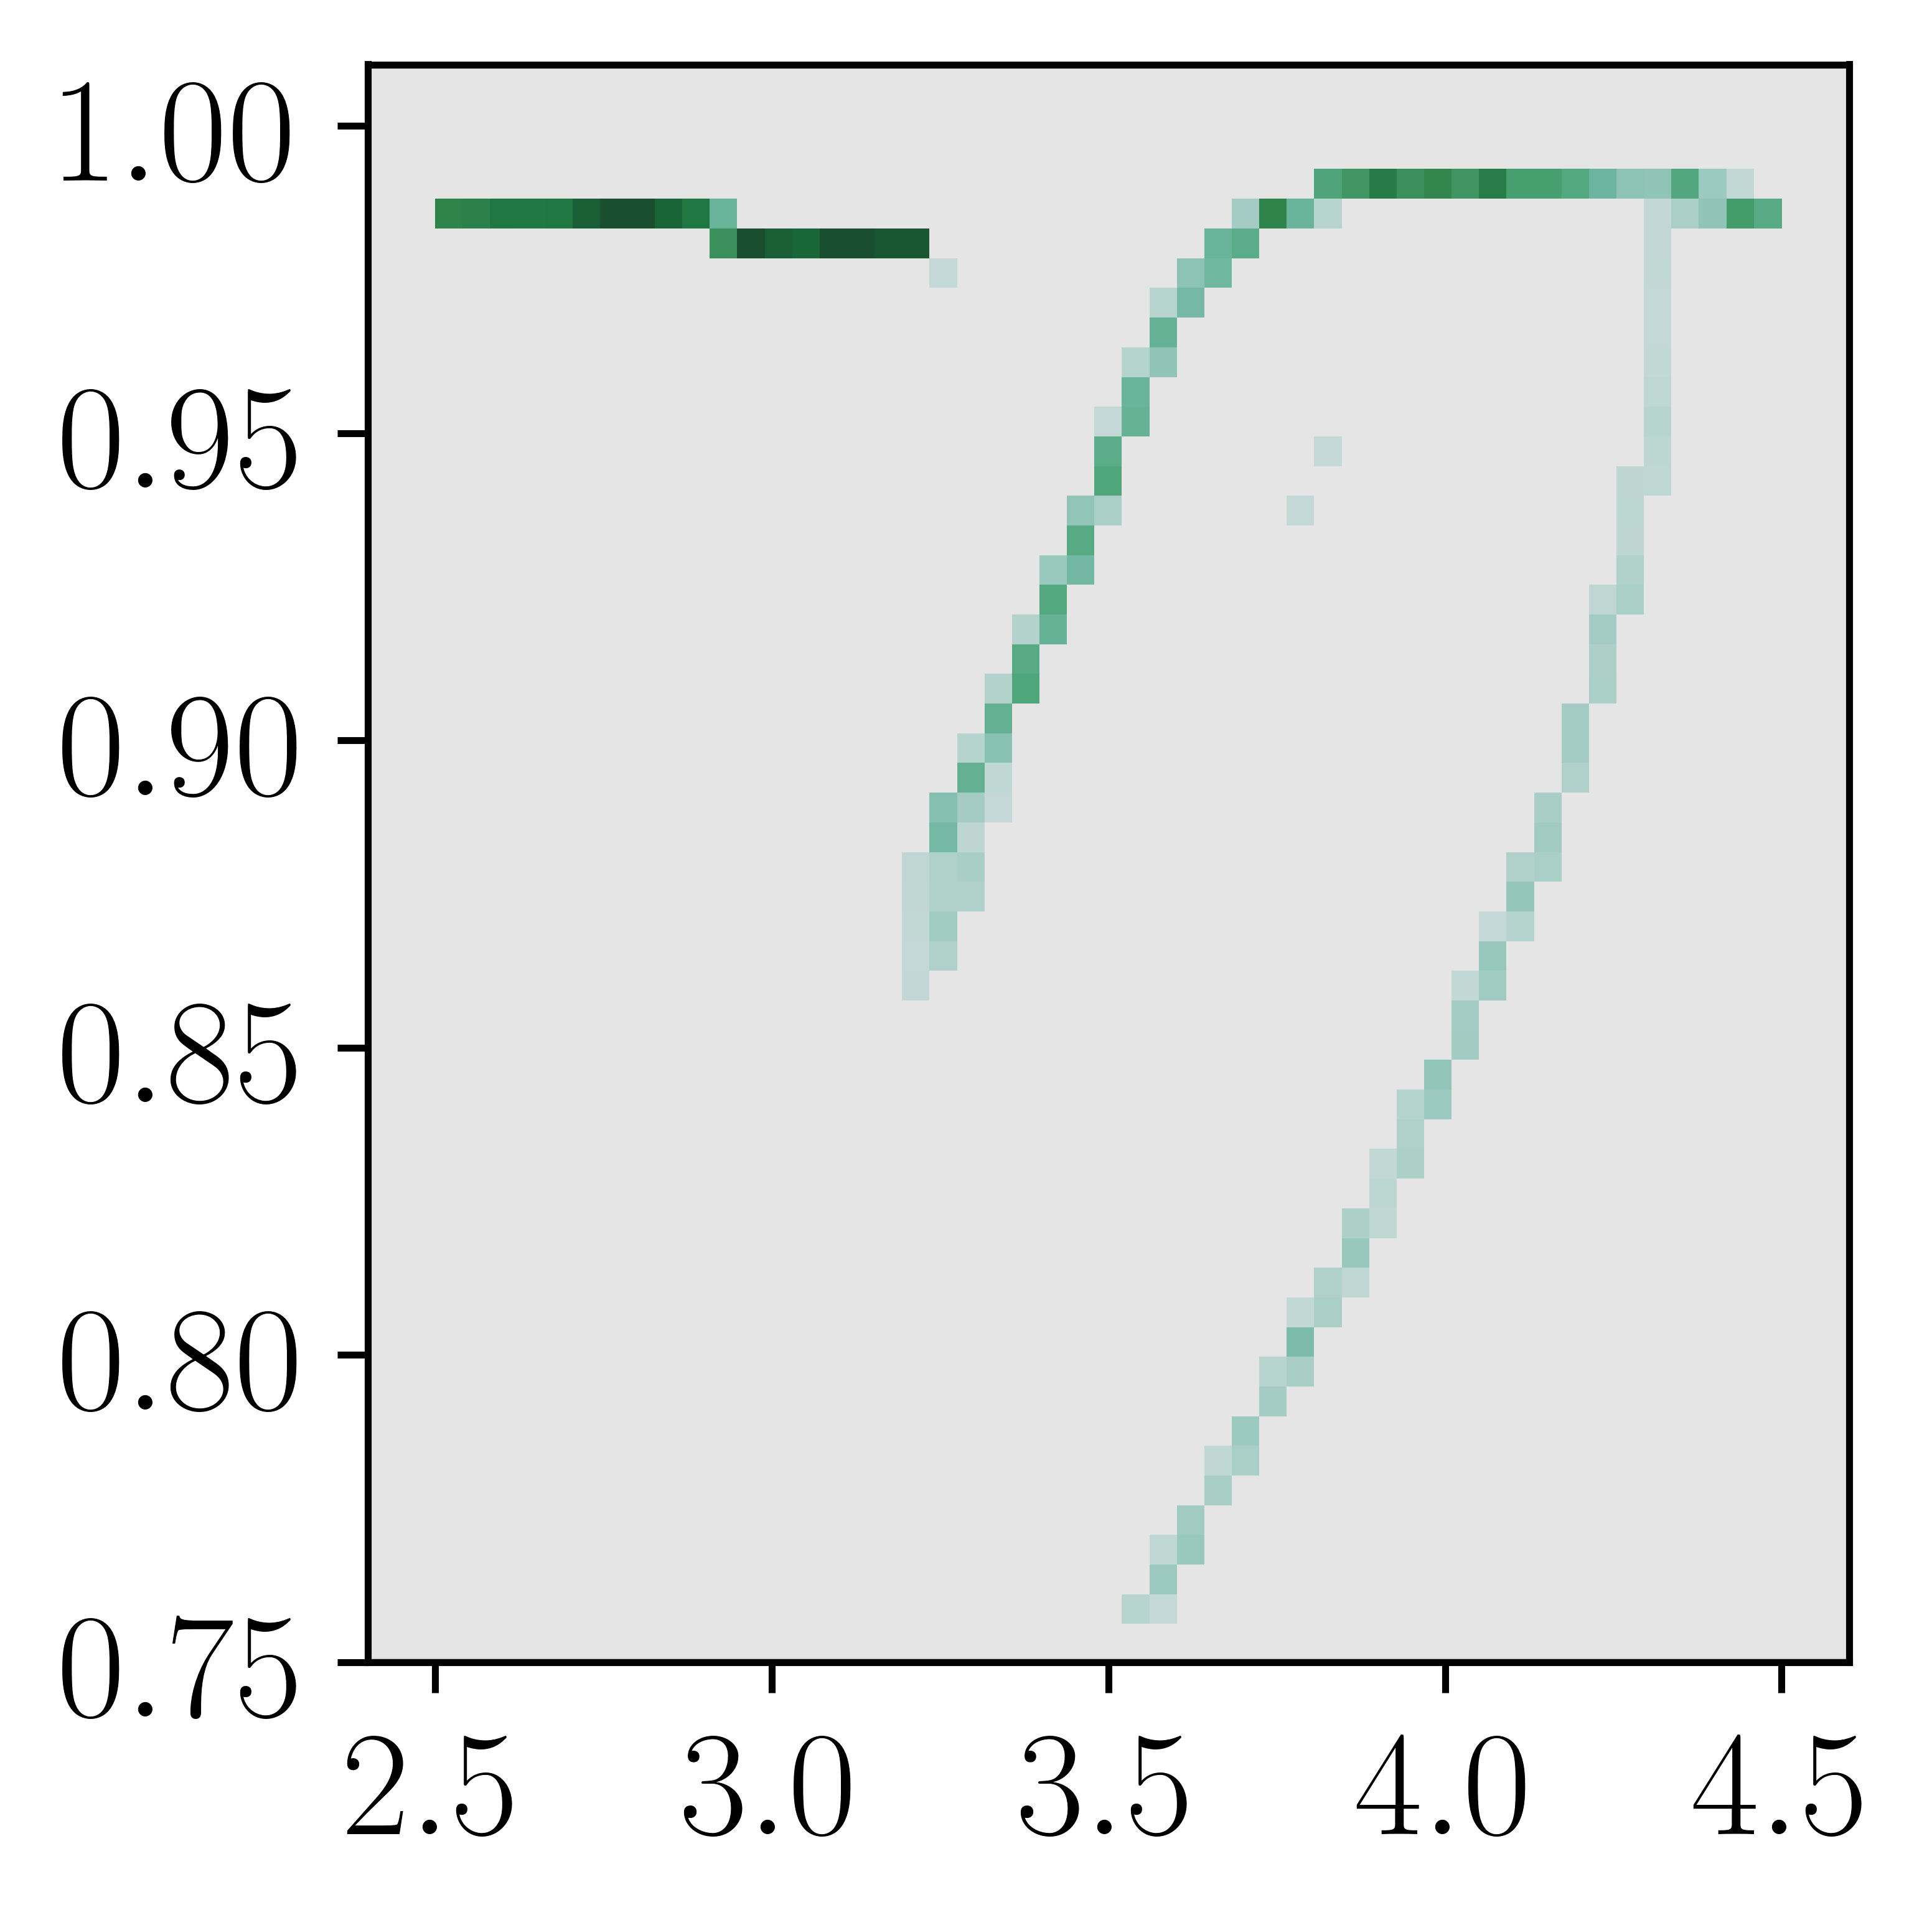

In [19]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import colorbar
from matplotlib import colors as mcolors

# figsize = np.array((16, 9)) * 0.4
figsize = np.array((16, 16)) * 0.2
markersize = 6
dpi = 1000 if 'inline' in matplotlib.get_backend() else 100
tcolors = np.vstack(((1, 1, 1, 1), plt.get_cmap('BuGn')(np.linspace(0.2, 1, 256))))
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', tcolors)
# norm = mcolors.LogNorm()
norm = mcolors.Normalize(vmin=0, vmax=1)

# xlim = (-0.0001, 115)
# ylim0 = (-0.43, 0.05)
# ylim1 = (0.45, 1.02)

# xlim = (-0.0001, 10.5)
# linthreshx, linscalex = 1e-3,  0.5
# ylim0 = (-0.04221, 0.00910)
# nyaxis0 = 50
# ylim1 = (0.45, 1.02)
# nyaxis1 = 50
# ylim2 = (-0.5, 2)
# nyaxis2 = 50
# linthreshy2, linscaley2 = 0.01, 1
# omega_tail_list = np.hstack((0, 10 ** np.linspace(-3, 1, 50)[:-1]))
# pickle_handle_list = ['C1', 'C4b']

xlim = (2.4, 4.6)
ylim1 = (0.75, 1.01)
nyaxis1 = 50
omega_tail_list = np.linspace(2.5, 4.5, 50)
pickle_handle_list = ['C1', 'C4b']

pickle_list = []
for pickle_handle in pickle_handle_list:
    pickle_name = '%s_jmp.pickle' % pickle_handle
    with open(pickle_name, 'rb') as handle:
        pickle_list.append(pickle.load(handle))

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
##########################################
# mean_eta, contour plot
wt_all = []
ty_all = []
for i0, _ in enumerate(data_list[:]):
    dx_list, dy_list, dz_list, wt_list, mean_eta_list, pickle_path_list, _ = _
    tidx = np.argsort(wt_list)
    wt_all.append(wt_list[tidx])
    ty_all.append(mean_eta_list[tidx] / np.pi)
wt_all = np.array(wt_all)
ty_all = np.array(ty_all)
bins = (omega_tail_list, np.linspace(np.hstack(ty_all).min(), np.hstack(ty_all).max(), nyaxis1))
tH, xedges, yedges = np.histogram2d(np.hstack(wt_all), np.hstack(ty_all), bins=bins)
im1 = axi.pcolormesh(*np.meshgrid(xedges, yedges), tH.T / len(data_list), cmap=cmap, norm=norm)
# axi.set_xscale('symlog', linthreshx=linthreshx, linscalex=linscalex)
axi.patch.set_alpha(0)
# axi.set_xlabel('$\\omega_t / \\tau_s$')
# axi.set_xticklabels([])
# axi.set_ylabel('$\\langle \\eta / \\pi \\rangle$')
# axi.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
axi.set_xlim(xlim)
axi.set_ylim(ylim1)
axi.axvspan(0, 0.015, alpha=0.05, color='gray')
axi.axvspan(0.015, 0.6, alpha=0.1, color='gray')
axi.axvspan(0.6, wt_list.max(), alpha=0.2, color='gray')
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.tight_layout()

print(axi.get_xlim(), axi.get_ylim())